In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import StepLR

C:\Users\Dancouga\anaconda3\envs\SINA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data from Excel file
file_path = "student_questions_for_labeling (Final).xlsx"
df = pd.read_excel(file_path)

In [3]:
# Prepare the data (questions and labels)
questions = df['Question'].tolist()
labels = df['Label'].tolist()

In [4]:
# Check the count of each label in the loaded dataset
label_counts = Counter(labels)
print("Label counts in the original dataset:", label_counts)

Label counts in the original dataset: Counter({1: 196, 2: 193, 3: 192})


In [5]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(encoded_labels), 
    y=encoded_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [6]:
# Split the data into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(questions, encoded_labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [7]:
# Define the tokenizer (using BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
# Create a Dataset class
class QuestionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# DataLoader for training, validation, and testing
MAX_LEN = 128
BATCH_SIZE = 8

train_dataset = QuestionDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = QuestionDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = QuestionDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [9]:
# Define the BERT-based model
class QuestionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(QuestionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [10]:
# Set up the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuestionClassifier(n_classes=len(label_encoder.classes_)).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    correct_predictions = 0
    losses = 0
    
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        
        correct_predictions += torch.sum(preds == labels)
        losses += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return correct_predictions.double() / len(data_loader.dataset), losses / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    correct_predictions = 0
    losses = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            
            correct_predictions += torch.sum(preds == labels)
            losses += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return correct_predictions.double() / len(data_loader.dataset), losses / len(data_loader), all_labels, all_preds

In [11]:
# Training loop with validation
epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss, _, _ = eval_model(model, val_loader, loss_fn, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch 1/100
Train Loss: 0.9908, Train Accuracy: 0.4581
Val Loss: 0.9388, Val Accuracy: 0.5747
Epoch 2/100
Train Loss: 0.6321, Train Accuracy: 0.7488
Val Loss: 0.8414, Val Accuracy: 0.5632
Epoch 3/100
Train Loss: 0.3860, Train Accuracy: 0.8571
Val Loss: 0.6508, Val Accuracy: 0.7126
Epoch 4/100
Train Loss: 0.1826, Train Accuracy: 0.9532
Val Loss: 0.7607, Val Accuracy: 0.7241
Epoch 5/100
Train Loss: 0.1034, Train Accuracy: 0.9729
Val Loss: 0.7377, Val Accuracy: 0.7471
Epoch 6/100
Train Loss: 0.0273, Train Accuracy: 0.9975
Val Loss: 0.9342, Val Accuracy: 0.7241
Epoch 7/100
Train Loss: 0.0150, Train Accuracy: 1.0000
Val Loss: 0.8711, Val Accuracy: 0.7701
Epoch 8/100
Train Loss: 0.0089, Train Accuracy: 1.0000
Val Loss: 0.8834, Val Accuracy: 0.7931
Epoch 9/100
Train Loss: 0.0064, Train Accuracy: 1.0000
Val Loss: 0.9156, Val Accuracy: 0.7816
Epoch 10/100
Train Loss: 0.0050, Train Accuracy: 1.0000
Val Loss: 0.9520, Val Accuracy: 0.7931
Epoch 11/100
Train Loss: 0.0042, Train Accuracy: 1.0000
Val

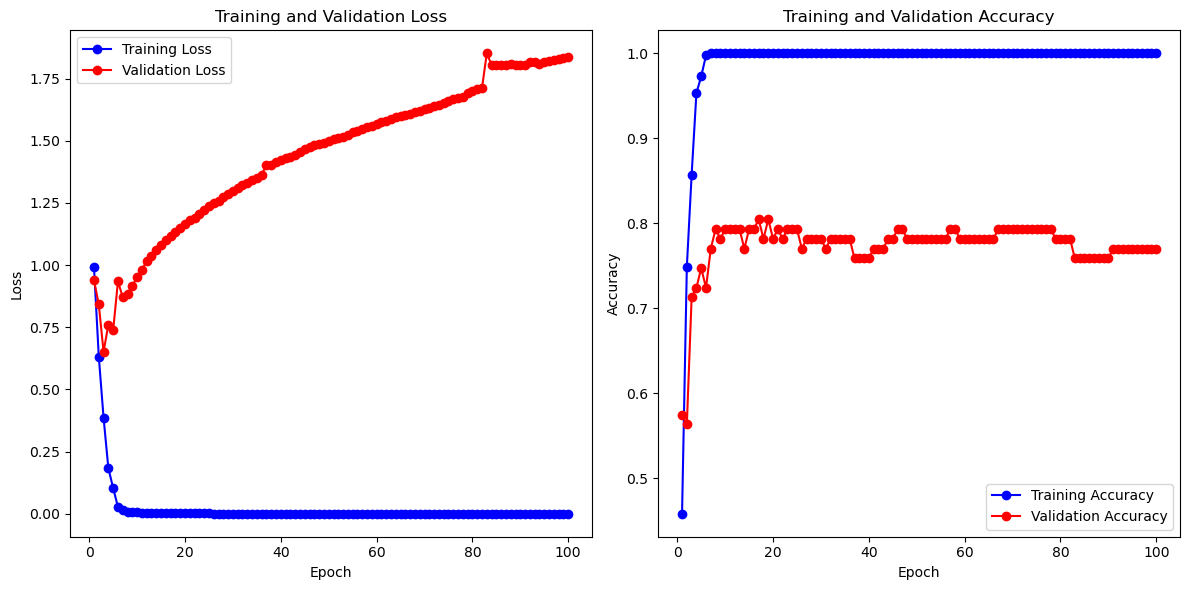

In [12]:
# Visualize training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='b', label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 1.3497, Test Accuracy: 0.8182


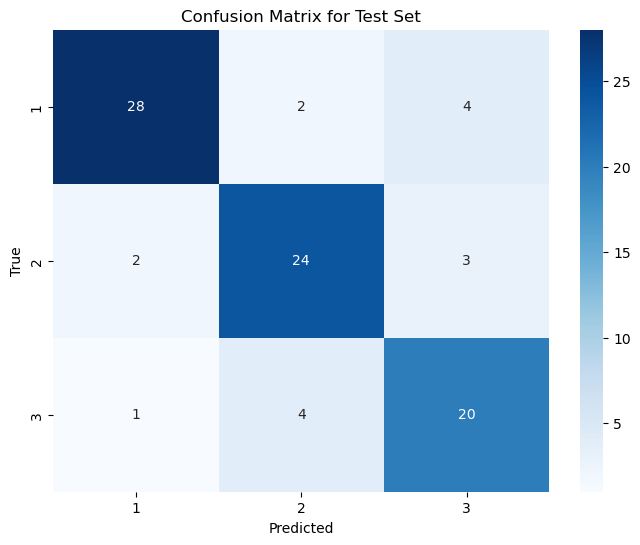

In [13]:
# Evaluate on the test set and calculate additional metrics
test_acc, test_loss, test_labels, test_preds = eval_model(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion Matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [14]:
# Classification Report for detailed performance metrics
print("Classification Report:")
report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)

# Display Precision, Recall, and F1 Score for each class
for label, metrics in report.items():
    if label in label_encoder.classes_:
        print(f"\nLabel: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

# Display overall averages
print("\nOverall Performance:")
print(f"  Average Precision: {report['weighted avg']['precision']:.4f}")
print(f"  Average Recall: {report['weighted avg']['recall']:.4f}")
print(f"  Average F1 Score: {report['weighted avg']['f1-score']:.4f}")
print(f"  Accuracy: {report['accuracy']:.4f}")

Classification Report:

Label: 1
  Precision: 0.9032
  Recall: 0.8235
  F1 Score: 0.8615
  Support: 34.0

Label: 2
  Precision: 0.8000
  Recall: 0.8276
  F1 Score: 0.8136
  Support: 29.0

Label: 3
  Precision: 0.7407
  Recall: 0.8000
  F1 Score: 0.7692
  Support: 25.0

Overall Performance:
  Average Precision: 0.8230
  Average Recall: 0.8182
  Average F1 Score: 0.8195
  Accuracy: 0.8182


C:\Users\Dancouga\AppData\Local\Temp\ipykernel_4560\2033045417.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label in label_encoder.classes_:


In [15]:
# Function to predict the label of a new question
def predict_question(question, model, tokenizer, max_len, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        question,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)
    
    return label_encoder.inverse_transform([prediction.cpu().item()])[0]


In [16]:
# Example usage
new_question = "Explain how deep learning can impact data analysis in educational settings."
predicted_label = predict_question(new_question, model, tokenizer, MAX_LEN, device)
print(f"Predicted Label for '{new_question}': {predicted_label}")

Predicted Label for 'Explain how deep learning can impact data analysis in educational settings.': 2


In [17]:
# Import random for selecting random questions
import random

# Encode the labels of the augmented dataset
encoded_labels_augmented = label_encoder.transform(labels)

# Create a mapping of questions to their original labels
question_to_label = dict(zip(questions, encoded_labels))

# Select 10 random questions from the dataset for prediction
random_questions = random.sample(questions, 10)

# Predict the label for each randomly selected question and print the result
print("Predicted Labels for Random Questions:")
for i, question in enumerate(random_questions, start=1):
    predicted_label = predict_question(question, model, tokenizer, MAX_LEN, device)
    original_label = label_encoder.inverse_transform([question_to_label[question]])[0]
    
    # Check if the prediction is correct
    is_correct = "(Correct)" if predicted_label == original_label else "(Incorrect)"
    
    # Print the result
    print(f"{i}. Question: '{question}'")
    print(f"   Original Label: {original_label}, Predicted Label: {predicted_label} {is_correct}\n")

Predicted Labels for Random Questions:
1. Question: 'How could we address ethical concerns regarding the bias of AI models used in recruitment?'
   Original Label: 3, Predicted Label: 3 (Correct)

2. Question: 'What steps could be taken to use AI to better predict student dropout rates and prevent them?'
   Original Label: 2, Predicted Label: 2 (Correct)

3. Question: 'Remove the emotion text label under the emoji and slightly increase the emoji size, but only to the extent that it doesn’t affect the canvas. Also, make the bar graph horizontal with emotion labels on the Y-axis, show values along with the graph, and make the stop button exit to the main screen instead of just stopping the function.'
   Original Label: 1, Predicted Label: 1 (Correct)

4. Question: 'How do I set up TensorFlow with CUDA 11.2 for GPU processing?'
   Original Label: 1, Predicted Label: 1 (Correct)

5. Question: 'In what ways could AI-based assessment tools be flawed, and what strategies could we implement to